In [1]:
# Image classification using Convolutional Neural Network on CIFAR-10 dataset

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

import math
import timeit
import os

In [2]:
# import cifar-10 data
import cifar10_data_helpers

In [3]:
cifar10_data_helpers.download_and_extract()

Dataset has already been downloaded.
Tar Extraction Done.


In [4]:
print(cifar10_data_helpers.data_path)

data/CIFAR-10/


In [5]:
# print the class names
class_names = cifar10_data_helpers.load_class_names()
print(class_names)

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
# load the training set
images_train, cls_train, labels_train = cifar10_data_helpers.load_training_data()

(50000, 32, 32, 3)
(50000,)
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [7]:
# load the test-set
images_test, cls_test, labels_test = cifar10_data_helpers.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [8]:
# check the size of the training and test sets
print("Size of the training set: ", len(images_train))
print("Size of the test set: ", len(images_test))

Size of the training set:  50000
Size of the test set:  10000


## Data Dimensions

In [9]:
# import the data dimensions from the cifar10_data_helpers file
from cifar10_data_helpers import img_size, num_channels, num_classes

print("Original Image Size: ", img_size)
print("No of channels: ", num_channels)
print("No of classes: ", num_classes)
# crop the images from 32x32 pixels to 24x24 pixels
img_size_cropped = 24
print("New Image Size: ", img_size_cropped)

Original Image Size:  32
No of channels:  3
No of classes:  10
New Image Size:  24


## Helper Function for plotting images

In [10]:
# Helper funciton to plot images
# plot 9 images in a 3x3 grid, and print the true and predicted classes below each image

# provide pixelated images as inputs to the neural network instead of smooth images which can be easily
# recognized by human eyes

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    
    # create figure with 3x3 sub-plots
    fig, axs = plt.subplots(3, 3)
    
    # Adjust vertical spacing if we need to print ensemble and best-net
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    for i, ax in enumerate(axs.flat):
        # Interpolation type
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
            
        # plot image
        ax.imshow(images[i, :, :, :], interpolation=interpolation)
        
        # name of the true class
        cls_true_name = class_names[cls_true[i]]
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # name of the predicted class
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0} \n Pred: {1}".format(cls_true_name, cls_pred_name)
            
        # show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    # display the plot
    plt.show()

## Plot few images to check if the data is correct

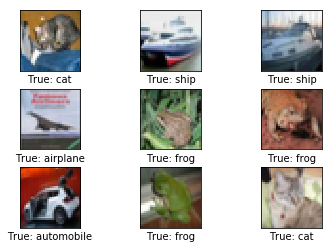

In [11]:
# Get the first 10 images from the test-set
images = images_test[0:9]

# Get the true classes for the above 10 images
cls_true = cls_test[0:9]

# plot the images and the labels using the plot helper function
plot_images(images=images, cls_true=cls_true, smooth=False)

## Placeholder variables 

In [12]:
# x is the placeholder variable for the input images
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

# y_true is the placeholder variable for the true labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

# y_true_cls is the placeholder variable for the true class of each image
y_true_cls = tf.argmax(y_true, dimension=1)

# reshape x as a 4-dim tensor
# x_image = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, num_channels])
# print(x_image)

In [13]:
# Configuration of neural network

# Convolutional Layer 1-------------------
# Convolution filters / kernels are 5x5 pixels.
# No.of filters = 16
filter_size1 = 5
num_filters1 = 32

# Convolutional Layer 2-------------------
filter_size2 = 5
num_filters2 = 32

# No. of neurons / units in the Fully Connected Layer
fc_size = 1024

poolsize = (2, 2)

In [14]:
# batch size
batch_size = 256

# learning rate
learning_rate = 1e-4

## Divide the Training and Test Sets into Minibatches

In [15]:
n_train_batches = len(images_train) // batch_size
n_test_batches = len(images_test) // batch_size

print("# of Training batches", n_train_batches)
print("# of Test batches", n_test_batches)

# of Training batches 195
# of Test batches 39


In [16]:
def new_weights(shape):
    # weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    weights = tf.Variable(tf.random_normal(shape, stddev=0.05))
    return weights

def new_biases(length):
    biases = tf.Variable(tf.constant(0.05, shape=[length]))
    return biases

## Helper function for creating a new Convolutional Layer

In [17]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    
    # shape of the filter-weights for the convolution - format defined by TensorFlow api.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    print(shape)
    
    # create new weights using the shape of the filters
    weights = new_weights(shape=shape)
    print(weights)
    
    # create a new bias for each filter
    biases = new_biases(length=num_filters)
    print(biases)
    
    # create the tensorflow operation for convolution
    # set the strides to 1 in all dimensions.
    # first (image-number) and last (input-channel) stride must always be 1.
    # set padding to 'SAME' meaning the input image is padded with zeroes for the size of the output
    # to remain same.
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    print(layer)
    
    # add the biases to the results of the convolution (each filter-channel is added with a bias)
    layer += biases
    
    # use pooling to downsample the image resolution
    if use_pooling:
        # consider a 2x2 max-pooling, i.e., selecting 2x2 windows and the largest value in each window, and
        # then move 2 pixels to the next window
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
    # apply ReLU to the conv layer, i.e., calculate max(x, 0) for each input pixel x and add some non-linearity
    # ReLU is normally executed before pooling, but since relu(max_pool(x)) == max_pool(relu(x)),
    # by max-pooling first, it saves 75% of the relu-operations
    layer = tf.nn.relu(layer)
    
    # return the computed convolutional layer and the filter-weights
    return layer, weights

## Helper function for flattening a layer 

In [18]:
def flatten_layer(layer):
    
    # get the shape of the input layer
    # shape of the input layer: [num_images, img_height, img_width, num_channels]
    layer_shape = layer.get_shape()
    print(layer_shape)
    
    # use tensorflow function to calcluate the no of features: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    print(num_features)
    
    # reshape the layer to [num_images, num_features]
    # use -1 to avoid changing the total size of the tensor due to reshaping
    layer_flat = tf.reshape(layer, [-1, num_features])
    print(layer_flat)
    
    # reutn the 2-D layer_flat from the 4-D layer and the number of features
    return layer_flat, num_features

## Helper Function for creating a new Fully-Connected Layer

In [19]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    
    # create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    print(weights)
    
    biases =  new_biases(length=num_outputs)
    print(biases)
    
    # calculate the layer using the matrix multiplication of the inputs and biases, and then add the bias-values
    # similar to how an output is calculated in linear regression model
    layer = tf.matmul(input, weights) + biases
    
    # use ReLU
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

## Helper Function for Pre-Processing the Input Images 

In [20]:
# For training - the input images are randomly cropped, randomly flipped horizontally, and the hue, 
# contrast and saturation are adjusted with random values

# For testing - the input images are cropped around the centre and nothing else is adjusted.

# create a function that takes a single image as input, and a boolean to build either the training or testing graph
def pre_process_image(image, training):
    
    if training:
        # randomly crop the input image
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        
        # randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)
        
        # randomly adjust hue, contrast, and saturation
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        # limit the image pixels between [0, 1] in case of overflow
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # for testing, crop the input image around the center so it is of the same size as the images randomly
        # cropped during training
        image = tf.image.resize_image_with_crop_or_pad(image, target_height=img_size_cropped, 
                                                       target_width=img_size_cropped)
        
    return image

In [21]:
# create a function to call the pre_process_image function for each image in the input image

def pre_process(images, training):
    
    # loop over all the input images using tensorflow and call the pre_process_image function that takes a
    # single image as input
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    
    return images

In [22]:
# create the pre-processing graph for tensorflow to plot the distorted images
distorted_images = pre_process(images=x, training=True)
print(distorted_images.shape)

(?, 24, 24, 3)


##  Convolutional Layer 1

In [23]:
# Create the first Convolutional Layer
# new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True)

layer_conv1, weights_conv1 = new_conv_layer(input=x, num_input_channels=num_channels, 
                                            filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)

print(layer_conv1)
print(weights_conv1)

[5, 5, 3, 32]
Tensor("Variable/read:0", shape=(5, 5, 3, 32), dtype=float32)
Tensor("Variable_1/read:0", shape=(32,), dtype=float32)
Tensor("Conv2D:0", shape=(?, 32, 32, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("Variable/read:0", shape=(5, 5, 3, 32), dtype=float32)


## Convolutional Layer 2

In [24]:
# Create the second Convolutional Layer

layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, 
                                            filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)
print(layer_conv2)
print(weights_conv2)

[5, 5, 32, 32]
Tensor("Variable_2/read:0", shape=(5, 5, 32, 32), dtype=float32)
Tensor("Variable_3/read:0", shape=(32,), dtype=float32)
Tensor("Conv2D_1:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("Relu_1:0", shape=(?, 8, 8, 32), dtype=float32)
Tensor("Variable_2/read:0", shape=(5, 5, 32, 32), dtype=float32)


## Flatten the output from the convolutional layer 2

In [25]:
# Flatten the output from the conv layers
# Outputs of the conv layers consist of 4-D tensors. Reshape / flatten these to 2-D tensors to provide these as
# inputs to the fully-connected layer
# num_features = 7x7x36

layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat)
print(num_features)

(?, 8, 8, 32)
2048
Tensor("Reshape:0", shape=(?, 2048), dtype=float32)
Tensor("Reshape:0", shape=(?, 2048), dtype=float32)
2048


## Fully-Connected Layer 1

In [26]:
# Fully-Connected Layer 1
# Add the first fully-connected layer (fc1) to the network
# input is the flattened layer from the previous convolution
# no of neurons or nodes in the fc1 is fc_size
# use ReLU for non-linear relations

layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)
print(layer_fc1)

Tensor("Variable_4/read:0", shape=(2048, 1024), dtype=float32)
Tensor("Variable_5/read:0", shape=(1024,), dtype=float32)
Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)


## Fully-Connected Layer 2

In [27]:
# Fully-Connected Layer 2
# output is a vector of length 10 to determine which of the classes the input image belongs to
# Since this is the final layer, ReLU is not used
# layer_fc2 gives the predicted output

layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)
print(layer_fc2)

Tensor("Variable_6/read:0", shape=(1024, 10), dtype=float32)
Tensor("Variable_7/read:0", shape=(10,), dtype=float32)
Tensor("add_3:0", shape=(?, 10), dtype=float32)


## Normalize the output of FC-2

In [28]:
# Normalize the output of the fully-connected layer 2 for proper estimation of the elements

# Limit each element to between zero and one, and the 10 elements sum to one using softmax function.
y_pred = tf.nn.softmax(layer_fc2)
print(y_pred)

# Find the class number which is the index of the largest element
y_pred_cls = tf.argmax(y_pred, dimension=1)
print(y_pred_cls)

Tensor("Softmax:0", shape=(?, 10), dtype=float32)
Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


## Calculate the cross-entropy and cost values

In [29]:
# Minimize the cross-entropy. ( to make its value as close to zero)
# To obtain a cross-entropy of value zero, the predicted output of the model must exactly match the desired output.

# Since TensorFlow's built-in function for calculating cross-entropy applies the softmax internally, use the output
# of layer_fc2 directly rather the softmax applied y_pred
# calculate cross_entropy for each of the image classifications
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

# find how well the model performs on each image individually by calculating the mean of the cross_entropy for
# all image classifications
cost = tf.reduce_mean(cross_entropy)

## Optimize the model

In [30]:
# Optimize the model using the loss value and learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# create a variable to track the global step
# set trainable to False which means that TensorFlow will not try to optimize this variable
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)


# use the optimizer to apply the gradients that minimize the loss
# and increment the global step counter as a single training step
# train_op = adam_optimizer.minimize(loss, global_step=global_step)
optimizer = optimizer.minimize(cost, global_step=global_step)

## Calculate the accuracy of the model 

In [31]:
# Test model's accuracy for measuring performance

# correct_prediction is a vector of booleans where the predicted class equals the true class of each image
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# calculate the classification accuracy by type-casting the vector of booleans to floats (False=0, True=1), and
# then find the average
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create the TensorFlow Session

In [32]:
# Intialize all variables and Create TensorFlow session
init = tf.global_variables_initializer()
sess = tf.Session()

## Save the model 

In [33]:
# Create a saver object to save all the variables of the neural network for storing and retrieving it later.

saver = tf.train.Saver()

# create a directory for saving the checkpoints that get written at regular intervals during optimization
save_dir = "checkpoints_cifar10_cnn/"
# create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# path for the checkpoint file
save_path = os.path.join(save_dir, "cifar10_cnn.ckpt")
if os.path.exists(save_path):
    print("Checkpoint created.")
else:
    print("No checkpoint exists as of now!!!!")

No checkpoint exists as of now!!!!


## Restore or Initialize Variables

In [34]:
# restore the latest checkpoint if available from the checkpoint directory
try:
    print("Trying to restore the latest checkpoint....")
    
    # search for the latest checkpoint
    last_ckpt_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    
    # load the data from the checkpoint file
    saver.restore(sess, save_path=last_ckpt_path)
    
    print("Checkpoint restored from: ", last_ckpt_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead...")
    sess.run(init)

Trying to restore the latest checkpoint....
Failed to restore checkpoint. Initializing variables instead...


## Helper Function to Get a Random Training Batch

In [35]:
# choose batch size for the training set
train_batch_size = batch_size

# create a function for selecting a random batch of images from the training set
def random_train_batch():
    
    # no of images in the training set
    num_train_images = len(images_train)
#     print("No of Training Images: ", num_train_images)
    
    # create a random index
    index = np.random.choice(num_train_images, size=train_batch_size, replace=False)
    
    # use the random index to select random images and labels
    x_train_batch = images_train[index, :, :, :]
    y_train_batch = labels_train[index, :]
    
    return x_train_batch, y_train_batch

## Helper Function to Perform Training

In [36]:
def optimize(n_epochs):
    
    finished = False
    curr_epoch = 0
    
    # start the timer
    start_time = timeit.default_timer()
    
    while (curr_epoch < n_epochs) and (not finished):
        
        # increment the no of iterations by 1
        curr_epoch += 1
        
        # get a batch of training examples
        # x_batch for images and y_batch for labels of these images
        x_train_batch, y_train_true_batch = random_train_batch()
        
        # create a dictionary of above training batches that needs to be fed to the placeholder variables
        # y_true_cls is not set as it is not used during training
        feed_dict_train = {x: x_train_batch, y_true: y_train_true_batch}
        
        for minibatch_i in range(n_train_batches):
            
            # iteration number
            iter = (curr_epoch - 1) * n_train_batches + minibatch_i
            
            if ((iter + 1) % n_train_batches == 0):
        
                # run the optimizer using the batch of training data
                # retrieve the global step counter
                global_step_, optimizer_, cost_ = sess.run([global_step, optimizer, cost], 
                                                           feed_dict=feed_dict_train)
            
                # calculate the accuracy of the training set.
                train_accuracy = sess.run(accuracy, feed_dict=feed_dict_train)

                
                epoch_msg = ("Epoch %i, Minibatch %i/%i ") % (curr_epoch, minibatch_i+1, n_train_batches)
                print(epoch_msg)

                # print the accuracy message
                output = "Training Accuracy: {0:>6.1%}"
                print(output.format(train_accuracy))
            
#                 print("Training Cost: ", cost_)
                
                
                # save all variables to a checkpoint and append the total_interations counter to the filename
                saver.save(sess, save_path=save_path, global_step=global_step_)
                print("Checkpoint Saved...")
                
                print("=====================================================================")
                print("=====================================================================")
        
    # end the timer
    end_time = timeit.default_timer()
        
    # total time taken to perform the iterations
    time_diff = end_time - start_time
    
    print(("Training Accuracy %f %%") % (train_accuracy))

    print("The code ran for %.1fs" % (time_diff))
    
    print("The code ran for %.2fm" % (time_diff / 60.))

## Helper Function to Plot Example Errors

In [37]:
# Plot examples of images from the test-set that have been misclassified

def plot_examples_errors(cls_pred, correct):
    
    # use tensorflow to get a list of boolean values to check whether each test-image has been correctly
    # classified, and a list for the predicted class of each image
    # cls_pred is the predicted class number for all images in the test-set
    
    # negate the boolean array
    incorrect = (correct == False)
    
    # get the images from the test-set that have been incorrectly classified
    images = images_test[incorrect]
    
    # get the predicted class for the above incorrectly classified images
    cls_pred = cls_pred[incorrect]
    
    # get the true class for the above images
    cls_true = cls_test[incorrect]
    
    # plot the first 9 images
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

## Helper Function to Plot Confusion Matrix as Text

In [38]:
# create a function to plot confusion matrix using scikit-learn

def plot_confusion_matrix(cls_pred):
    
    # get the true classifications for the test-set
    cls_true = cls_test
    
    # create a dictionary of test examples
    feed_dict_test = {x: images_test, y_true: labels_test, y_true_cls: cls_true}
    
    # cls_pred is an array of the predicted class number for all images in the test-set
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # print the confusion matrix as text
    # print(cm)
    for i in range(num_classes):
        # append the class name to each line
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)
        
    # print the class numbers for easy reference
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
    
    # plot the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # adjust the plot
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

## Helper Function for Calculating Classifications

In [39]:
# create a function to calculate the predicted classes of images and return a boolean array to check if the
# classification of each image is correct

# split the dataset into smaller batches
batch_size = batch_size

def predict_cls(images, labels, cls_true):
    
    # find the total no of images
    num_images = len(images)
    print(num_images)
    
    # allocate an array for the predicted class which will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    # calculate the predicted classes for the batches by iterating through all the batches
    # starting index (i) for the next batch
    i = 0
    
    while i < num_images:
        # ending index (j) for the next batch
        j = min(i + batch_size, num_images)
        
        # get the images from the test-set between i and j
#         images = images[i:j, :]
        
        # get the associated labels from the test-set between i and j
#         labels = labels[i:j, :]
        
        # create a feed-dict with these labels and images
        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}
        
        # calculate the predicted class using TensorFlow
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        
        # set the start-index of the next batch to the end-index of the current batch
        i = j
    
    # create a boolean array to check whether each image is correctly classified
    correct = (cls_true == cls_pred)
    
    return correct, cls_pred

## Helper Functions for calculating the predicted class, classification accuracy, and the performance of the test-set

In [40]:
# create a function for calculating the predicted class
def predict_cls_test():
    return predict_cls(images=images_test, labels=labels_test, cls_true=cls_test)

In [41]:
# create a function for calculating the classfication accuracy and the no of correct classifications
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

In [42]:
# create a function to print the classification accuracy on the test-set
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    # for all the images in the test-set, calculate the predicted classes and check if they are correct
    correct, cls_pred = predict_cls_test()
    
    # calculate the classification accuracy and the no of correct classifications
    test_accuracy, num_correct = classification_accuracy(correct)
    
    # find the no of images being classified
    num_images = len(correct)
    
    # print the accuracy
    msg = "Test-Set Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(test_accuracy, num_correct, num_images))
    
    # plot some examples of misclassifications
    if show_example_errors:
        print("Example errors:")
        plot_examples_errors(cls_pred=cls_pred, correct=correct)
        
    # plot the confusion matrix
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Helper function for plotting convolutional weights

In [43]:
# create a function to visualize the weights of the convolutional filters

def plot_conv_weights(weights, input_channel=0):
    
    # get the values of the weight-variables from TensorFlow.
    w = sess.run(weights)
    
    # print statistics for the weights
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # get the lowest and the highest values for the weights in order to correct the color intensity
    # across the images to compare them with each other
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))
    
    # no of filters used in the conv layer
    num_filters = w.shape[3]
    
    # no of grids to plot. (rounded up, square-root of the no of filters)
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # create figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        
        # only plot the valid filter-weights
        if i < num_filters:
            # get the weights for the i'th filter of the input channel
            # refer new_conv_layer() for the shape of this 4-D tensor
            # shape = [filter_size, filter_size, num_input_channels, num_filters]
            img = w[:, :, input_channel, i]
            
            # plot the image
            ax.imshow(img, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap='seismic')
            
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    # display the plot
    plt.show()

## Helper-function for plotting the output of a convolutional layer

In [44]:
# create a function to plot the output of the convolutional layers

def plot_conv_layer(layer_output, image):
    
    # output of the convolutional layer is a 4-D tensor
    # create a feed-dict containing just one image, no need to feed y_true
    feed_dict = {x: [image]}
    
    # Calculate and retrieve the output values of the layer when inputting the image
    values = sess.run(layer_output, feed_dict=feed_dict)
    print(values)
    
    # get the lowest and the highest values so that the images can be compared with each other based on the
    # correct color intensity
    values_min = np.min(values)
    values_max = np.max(values)
    
    # no of image channels output by the conv layer
    num_img_channels = values.shape[3]
    print(num_img_channels)
    
    # no of grids to plot. (rounded up, square-root of the no of image channels)
    num_grids = math.ceil(math.sqrt(num_img_channels))
    print(num_grids)
    
    # create figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        
        # only plot the valid image channels
        if i < num_img_channels:
            # get the weights for the i'th filter of the input channel
            # refer new_conv_layer() for the shape of this 4-D tensor
            # shape = [filter_size, filter_size, num_input_channels, num_filters]
            img = values[0, :, :, i]
            
            # plot the image
            ax.imshow(img, interpolation='nearest', cmap='binary')
            
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    # display the plot
    plt.show()

## Helper Function to plot the distorted input images

In [45]:
# create a function to plot the distorted images from the input by applying the pre-processing function

def plot_distorted_image(image, cls_true):
    
    # repeat a single input image, say 9 times
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)
    
    # create a feed-dict of these duplicate images
    feed_dict_duplicate = {x: image_duplicates}
    
    # calculate only the pre-processing which distorts the images in the feed-dict
    images = sess.run(distorted_images, feed_dict=feed_dict_duplicate)
    
    # get the true classifications for these images
    cls_true = np.repeat(cls_true, 9)
    
    # plot the duplicate images
    plot_images(images=images, cls_true=cls_true)

In [46]:
# create a function for getting an image and its class number from the test-set
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

## Plot the distorted images

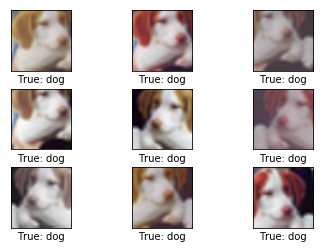

In [47]:
# get an image and its true class from the test set
img, cls = get_test_image(16)
# print(img)
# print(cls)

# plot 9 random distortions of the image
plot_distorted_image(img, cls)

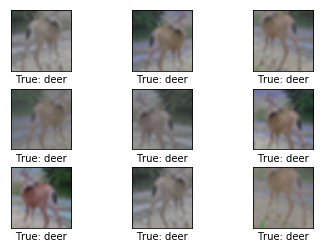

In [48]:
# plot another distorted image
img, cls = get_test_image(100)
plot_distorted_image(img, cls)

## Perform Training

## Performance of the Model before any Optimization

In [49]:
print("Accuracy of the model before training")
print_test_accuracy()

Accuracy of the model before training
10000
Test-Set Accuracy: 10.0% (1000 / 10000)


## Performance of the Model after 5000 epochs

In [50]:
print("Starting Training Operation with a batch size of", train_batch_size)
optimize(n_epochs=5000)

Starting Training Operation with a batch size of 256
Epoch 1, Minibatch 195/195 
Training Accuracy:   9.4%
Checkpoint Saved...
Epoch 2, Minibatch 195/195 
Training Accuracy:  12.5%
Checkpoint Saved...
Epoch 3, Minibatch 195/195 
Training Accuracy:  12.9%
Checkpoint Saved...
Epoch 4, Minibatch 195/195 
Training Accuracy:  15.2%
Checkpoint Saved...
Epoch 5, Minibatch 195/195 
Training Accuracy:  11.7%
Checkpoint Saved...
Epoch 6, Minibatch 195/195 
Training Accuracy:  14.1%
Checkpoint Saved...
Epoch 7, Minibatch 195/195 
Training Accuracy:   8.2%
Checkpoint Saved...
Epoch 8, Minibatch 195/195 
Training Accuracy:  10.9%
Checkpoint Saved...
Epoch 9, Minibatch 195/195 
Training Accuracy:  12.1%
Checkpoint Saved...
Epoch 10, Minibatch 195/195 
Training Accuracy:  14.5%
Checkpoint Saved...
Epoch 11, Minibatch 195/195 
Training Accuracy:  14.1%
Checkpoint Saved...
Epoch 12, Minibatch 195/195 
Training Accuracy:  15.6%
Checkpoint Saved...
Epoch 13, Minibatch 195/195 
Training Accuracy:  17.6%
C

Checkpoint Saved...
Epoch 40, Minibatch 195/195 
Training Accuracy:  31.2%
Checkpoint Saved...
Epoch 41, Minibatch 195/195 
Training Accuracy:  27.7%
Checkpoint Saved...
Epoch 42, Minibatch 195/195 
Training Accuracy:  30.9%
Checkpoint Saved...
Epoch 43, Minibatch 195/195 
Training Accuracy:  27.3%
Checkpoint Saved...
Epoch 44, Minibatch 195/195 
Training Accuracy:  35.2%
Checkpoint Saved...
Epoch 45, Minibatch 195/195 
Training Accuracy:  34.0%
Checkpoint Saved...
Epoch 46, Minibatch 195/195 
Training Accuracy:  34.4%
Checkpoint Saved...
Epoch 47, Minibatch 195/195 
Training Accuracy:  29.3%
Checkpoint Saved...
Epoch 48, Minibatch 195/195 
Training Accuracy:  34.8%
Checkpoint Saved...
Epoch 49, Minibatch 195/195 
Training Accuracy:  30.5%
Checkpoint Saved...
Epoch 50, Minibatch 195/195 
Training Accuracy:  29.7%
Checkpoint Saved...
Epoch 51, Minibatch 195/195 
Training Accuracy:  33.2%
Checkpoint Saved...
Epoch 52, Minibatch 195/195 
Training Accuracy:  32.0%
Checkpoint Saved...
Epoch

Checkpoint Saved...
Epoch 79, Minibatch 195/195 
Training Accuracy:  39.1%
Checkpoint Saved...
Epoch 80, Minibatch 195/195 
Training Accuracy:  35.5%
Checkpoint Saved...
Epoch 81, Minibatch 195/195 
Training Accuracy:  32.0%
Checkpoint Saved...
Epoch 82, Minibatch 195/195 
Training Accuracy:  35.2%
Checkpoint Saved...
Epoch 83, Minibatch 195/195 
Training Accuracy:  35.9%
Checkpoint Saved...
Epoch 84, Minibatch 195/195 
Training Accuracy:  37.1%
Checkpoint Saved...
Epoch 85, Minibatch 195/195 
Training Accuracy:  39.1%
Checkpoint Saved...
Epoch 86, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 87, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 88, Minibatch 195/195 
Training Accuracy:  36.3%
Checkpoint Saved...
Epoch 89, Minibatch 195/195 
Training Accuracy:  39.8%
Checkpoint Saved...
Epoch 90, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 91, Minibatch 195/195 
Training Accuracy:  41.4%
Checkpoint Saved...
Epoch

Checkpoint Saved...
Epoch 118, Minibatch 195/195 
Training Accuracy:  41.0%
Checkpoint Saved...
Epoch 119, Minibatch 195/195 
Training Accuracy:  39.5%
Checkpoint Saved...
Epoch 120, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 121, Minibatch 195/195 
Training Accuracy:  42.6%
Checkpoint Saved...
Epoch 122, Minibatch 195/195 
Training Accuracy:  38.7%
Checkpoint Saved...
Epoch 123, Minibatch 195/195 
Training Accuracy:  34.0%
Checkpoint Saved...
Epoch 124, Minibatch 195/195 
Training Accuracy:  41.8%
Checkpoint Saved...
Epoch 125, Minibatch 195/195 
Training Accuracy:  42.6%
Checkpoint Saved...
Epoch 126, Minibatch 195/195 
Training Accuracy:  41.0%
Checkpoint Saved...
Epoch 127, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 128, Minibatch 195/195 
Training Accuracy:  44.1%
Checkpoint Saved...
Epoch 129, Minibatch 195/195 
Training Accuracy:  40.6%
Checkpoint Saved...
Epoch 130, Minibatch 195/195 
Training Accuracy:  32.0%
Checkpoint S

Checkpoint Saved...
Epoch 156, Minibatch 195/195 
Training Accuracy:  41.0%
Checkpoint Saved...
Epoch 157, Minibatch 195/195 
Training Accuracy:  48.4%
Checkpoint Saved...
Epoch 158, Minibatch 195/195 
Training Accuracy:  41.4%
Checkpoint Saved...
Epoch 159, Minibatch 195/195 
Training Accuracy:  41.8%
Checkpoint Saved...
Epoch 160, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 161, Minibatch 195/195 
Training Accuracy:  42.6%
Checkpoint Saved...
Epoch 162, Minibatch 195/195 
Training Accuracy:  46.5%
Checkpoint Saved...
Epoch 163, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 164, Minibatch 195/195 
Training Accuracy:  44.9%
Checkpoint Saved...
Epoch 165, Minibatch 195/195 
Training Accuracy:  37.1%
Checkpoint Saved...
Epoch 166, Minibatch 195/195 
Training Accuracy:  38.7%
Checkpoint Saved...
Epoch 167, Minibatch 195/195 
Training Accuracy:  43.4%
Checkpoint Saved...
Epoch 168, Minibatch 195/195 
Training Accuracy:  39.5%
Checkpoint S

Checkpoint Saved...
Epoch 194, Minibatch 195/195 
Training Accuracy:  46.5%
Checkpoint Saved...
Epoch 195, Minibatch 195/195 
Training Accuracy:  46.1%
Checkpoint Saved...
Epoch 196, Minibatch 195/195 
Training Accuracy:  41.0%
Checkpoint Saved...
Epoch 197, Minibatch 195/195 
Training Accuracy:  48.0%
Checkpoint Saved...
Epoch 198, Minibatch 195/195 
Training Accuracy:  41.4%
Checkpoint Saved...
Epoch 199, Minibatch 195/195 
Training Accuracy:  43.8%
Checkpoint Saved...
Epoch 200, Minibatch 195/195 
Training Accuracy:  39.5%
Checkpoint Saved...
Epoch 201, Minibatch 195/195 
Training Accuracy:  45.3%
Checkpoint Saved...
Epoch 202, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 203, Minibatch 195/195 
Training Accuracy:  38.7%
Checkpoint Saved...
Epoch 204, Minibatch 195/195 
Training Accuracy:  46.1%
Checkpoint Saved...
Epoch 205, Minibatch 195/195 
Training Accuracy:  39.8%
Checkpoint Saved...
Epoch 206, Minibatch 195/195 
Training Accuracy:  39.5%
Checkpoint S

Checkpoint Saved...
Epoch 232, Minibatch 195/195 
Training Accuracy:  45.7%
Checkpoint Saved...
Epoch 233, Minibatch 195/195 
Training Accuracy:  45.3%
Checkpoint Saved...
Epoch 234, Minibatch 195/195 
Training Accuracy:  46.5%
Checkpoint Saved...
Epoch 235, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 236, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 237, Minibatch 195/195 
Training Accuracy:  46.1%
Checkpoint Saved...
Epoch 238, Minibatch 195/195 
Training Accuracy:  44.9%
Checkpoint Saved...
Epoch 239, Minibatch 195/195 
Training Accuracy:  44.9%
Checkpoint Saved...
Epoch 240, Minibatch 195/195 
Training Accuracy:  48.4%
Checkpoint Saved...
Epoch 241, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 242, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 243, Minibatch 195/195 
Training Accuracy:  46.9%
Checkpoint Saved...
Epoch 244, Minibatch 195/195 
Training Accuracy:  45.7%
Checkpoint S

Checkpoint Saved...
Epoch 270, Minibatch 195/195 
Training Accuracy:  45.3%
Checkpoint Saved...
Epoch 271, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 272, Minibatch 195/195 
Training Accuracy:  43.0%
Checkpoint Saved...
Epoch 273, Minibatch 195/195 
Training Accuracy:  40.2%
Checkpoint Saved...
Epoch 274, Minibatch 195/195 
Training Accuracy:  44.9%
Checkpoint Saved...
Epoch 275, Minibatch 195/195 
Training Accuracy:  39.1%
Checkpoint Saved...
Epoch 276, Minibatch 195/195 
Training Accuracy:  42.2%
Checkpoint Saved...
Epoch 277, Minibatch 195/195 
Training Accuracy:  44.9%
Checkpoint Saved...
Epoch 278, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 279, Minibatch 195/195 
Training Accuracy:  51.6%
Checkpoint Saved...
Epoch 280, Minibatch 195/195 
Training Accuracy:  46.9%
Checkpoint Saved...
Epoch 281, Minibatch 195/195 
Training Accuracy:  47.7%
Checkpoint Saved...
Epoch 282, Minibatch 195/195 
Training Accuracy:  44.1%
Checkpoint S

Checkpoint Saved...
Epoch 308, Minibatch 195/195 
Training Accuracy:  46.1%
Checkpoint Saved...
Epoch 309, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 310, Minibatch 195/195 
Training Accuracy:  45.3%
Checkpoint Saved...
Epoch 311, Minibatch 195/195 
Training Accuracy:  46.5%
Checkpoint Saved...
Epoch 312, Minibatch 195/195 
Training Accuracy:  45.7%
Checkpoint Saved...
Epoch 313, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 314, Minibatch 195/195 
Training Accuracy:  47.7%
Checkpoint Saved...
Epoch 315, Minibatch 195/195 
Training Accuracy:  44.9%
Checkpoint Saved...
Epoch 316, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 317, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 318, Minibatch 195/195 
Training Accuracy:  43.4%
Checkpoint Saved...
Epoch 319, Minibatch 195/195 
Training Accuracy:  39.1%
Checkpoint Saved...
Epoch 320, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint S

Checkpoint Saved...
Epoch 346, Minibatch 195/195 
Training Accuracy:  48.0%
Checkpoint Saved...
Epoch 347, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 348, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 349, Minibatch 195/195 
Training Accuracy:  51.2%
Checkpoint Saved...
Epoch 350, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 351, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 352, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 353, Minibatch 195/195 
Training Accuracy:  48.0%
Checkpoint Saved...
Epoch 354, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 355, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 356, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 357, Minibatch 195/195 
Training Accuracy:  48.0%
Checkpoint Saved...
Epoch 358, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint S

Checkpoint Saved...
Epoch 384, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 385, Minibatch 195/195 
Training Accuracy:  45.7%
Checkpoint Saved...
Epoch 386, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 387, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 388, Minibatch 195/195 
Training Accuracy:  46.9%
Checkpoint Saved...
Epoch 389, Minibatch 195/195 
Training Accuracy:  45.3%
Checkpoint Saved...
Epoch 390, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 391, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint Saved...
Epoch 392, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 393, Minibatch 195/195 
Training Accuracy:  49.6%
Checkpoint Saved...
Epoch 394, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 395, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 396, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint S

Checkpoint Saved...
Epoch 422, Minibatch 195/195 
Training Accuracy:  48.0%
Checkpoint Saved...
Epoch 423, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 424, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 425, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 426, Minibatch 195/195 
Training Accuracy:  46.5%
Checkpoint Saved...
Epoch 427, Minibatch 195/195 
Training Accuracy:  47.7%
Checkpoint Saved...
Epoch 428, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint Saved...
Epoch 429, Minibatch 195/195 
Training Accuracy:  51.2%
Checkpoint Saved...
Epoch 430, Minibatch 195/195 
Training Accuracy:  49.6%
Checkpoint Saved...
Epoch 431, Minibatch 195/195 
Training Accuracy:  44.5%
Checkpoint Saved...
Epoch 432, Minibatch 195/195 
Training Accuracy:  49.6%
Checkpoint Saved...
Epoch 433, Minibatch 195/195 
Training Accuracy:  50.0%
Checkpoint Saved...
Epoch 434, Minibatch 195/195 
Training Accuracy:  46.1%
Checkpoint S

Checkpoint Saved...
Epoch 460, Minibatch 195/195 
Training Accuracy:  50.0%
Checkpoint Saved...
Epoch 461, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 462, Minibatch 195/195 
Training Accuracy:  50.8%
Checkpoint Saved...
Epoch 463, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 464, Minibatch 195/195 
Training Accuracy:  53.1%
Checkpoint Saved...
Epoch 465, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 466, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 467, Minibatch 195/195 
Training Accuracy:  53.1%
Checkpoint Saved...
Epoch 468, Minibatch 195/195 
Training Accuracy:  49.6%
Checkpoint Saved...
Epoch 469, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 470, Minibatch 195/195 
Training Accuracy:  51.6%
Checkpoint Saved...
Epoch 471, Minibatch 195/195 
Training Accuracy:  47.7%
Checkpoint Saved...
Epoch 472, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint S

Checkpoint Saved...
Epoch 498, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 499, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 500, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 501, Minibatch 195/195 
Training Accuracy:  46.9%
Checkpoint Saved...
Epoch 502, Minibatch 195/195 
Training Accuracy:  49.6%
Checkpoint Saved...
Epoch 503, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 504, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 505, Minibatch 195/195 
Training Accuracy:  51.2%
Checkpoint Saved...
Epoch 506, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 507, Minibatch 195/195 
Training Accuracy:  47.7%
Checkpoint Saved...
Epoch 508, Minibatch 195/195 
Training Accuracy:  50.0%
Checkpoint Saved...
Epoch 509, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 510, Minibatch 195/195 
Training Accuracy:  47.7%
Checkpoint S

Checkpoint Saved...
Epoch 536, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 537, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 538, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 539, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 540, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 541, Minibatch 195/195 
Training Accuracy:  48.4%
Checkpoint Saved...
Epoch 542, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 543, Minibatch 195/195 
Training Accuracy:  47.3%
Checkpoint Saved...
Epoch 544, Minibatch 195/195 
Training Accuracy:  51.2%
Checkpoint Saved...
Epoch 545, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 546, Minibatch 195/195 
Training Accuracy:  55.5%
Checkpoint Saved...
Epoch 547, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 548, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint S

Checkpoint Saved...
Epoch 574, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 575, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 576, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 577, Minibatch 195/195 
Training Accuracy:  51.2%
Checkpoint Saved...
Epoch 578, Minibatch 195/195 
Training Accuracy:  50.8%
Checkpoint Saved...
Epoch 579, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 580, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 581, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 582, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 583, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 584, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 585, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 586, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint S

Checkpoint Saved...
Epoch 612, Minibatch 195/195 
Training Accuracy:  50.8%
Checkpoint Saved...
Epoch 613, Minibatch 195/195 
Training Accuracy:  53.1%
Checkpoint Saved...
Epoch 614, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 615, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 616, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 617, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 618, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 619, Minibatch 195/195 
Training Accuracy:  51.6%
Checkpoint Saved...
Epoch 620, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 621, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 622, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 623, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 624, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint S

Checkpoint Saved...
Epoch 650, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint Saved...
Epoch 651, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 652, Minibatch 195/195 
Training Accuracy:  51.2%
Checkpoint Saved...
Epoch 653, Minibatch 195/195 
Training Accuracy:  47.7%
Checkpoint Saved...
Epoch 654, Minibatch 195/195 
Training Accuracy:  50.8%
Checkpoint Saved...
Epoch 655, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 656, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 657, Minibatch 195/195 
Training Accuracy:  51.2%
Checkpoint Saved...
Epoch 658, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 659, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 660, Minibatch 195/195 
Training Accuracy:  48.0%
Checkpoint Saved...
Epoch 661, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 662, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint S

Checkpoint Saved...
Epoch 688, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 689, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 690, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 691, Minibatch 195/195 
Training Accuracy:  50.0%
Checkpoint Saved...
Epoch 692, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 693, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 694, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 695, Minibatch 195/195 
Training Accuracy:  53.1%
Checkpoint Saved...
Epoch 696, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 697, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 698, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 699, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 700, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint S

Checkpoint Saved...
Epoch 726, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 727, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 728, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint Saved...
Epoch 729, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 730, Minibatch 195/195 
Training Accuracy:  50.8%
Checkpoint Saved...
Epoch 731, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 732, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 733, Minibatch 195/195 
Training Accuracy:  49.6%
Checkpoint Saved...
Epoch 734, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 735, Minibatch 195/195 
Training Accuracy:  55.5%
Checkpoint Saved...
Epoch 736, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint Saved...
Epoch 737, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 738, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint S

Checkpoint Saved...
Epoch 764, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint Saved...
Epoch 765, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 766, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 767, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 768, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 769, Minibatch 195/195 
Training Accuracy:  52.3%
Checkpoint Saved...
Epoch 770, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 771, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 772, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 773, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 774, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 775, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 776, Minibatch 195/195 
Training Accuracy:  50.0%
Checkpoint S

Checkpoint Saved...
Epoch 802, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 803, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 804, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 805, Minibatch 195/195 
Training Accuracy:  50.0%
Checkpoint Saved...
Epoch 806, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 807, Minibatch 195/195 
Training Accuracy:  55.5%
Checkpoint Saved...
Epoch 808, Minibatch 195/195 
Training Accuracy:  50.8%
Checkpoint Saved...
Epoch 809, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 810, Minibatch 195/195 
Training Accuracy:  49.2%
Checkpoint Saved...
Epoch 811, Minibatch 195/195 
Training Accuracy:  55.5%
Checkpoint Saved...
Epoch 812, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 813, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 814, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint S

Checkpoint Saved...
Epoch 840, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 841, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 842, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 843, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 844, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 845, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 846, Minibatch 195/195 
Training Accuracy:  51.6%
Checkpoint Saved...
Epoch 847, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 848, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 849, Minibatch 195/195 
Training Accuracy:  53.1%
Checkpoint Saved...
Epoch 850, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 851, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 852, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint S

Checkpoint Saved...
Epoch 878, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 879, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 880, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 881, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 882, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 883, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 884, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 885, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 886, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 887, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 888, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 889, Minibatch 195/195 
Training Accuracy:  48.8%
Checkpoint Saved...
Epoch 890, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint S

Checkpoint Saved...
Epoch 916, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 917, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 918, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 919, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 920, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 921, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 922, Minibatch 195/195 
Training Accuracy:  55.5%
Checkpoint Saved...
Epoch 923, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 924, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 925, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 926, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 927, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 928, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint S

Checkpoint Saved...
Epoch 954, Minibatch 195/195 
Training Accuracy:  51.6%
Checkpoint Saved...
Epoch 955, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 956, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 957, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 958, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 959, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 960, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 961, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 962, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 963, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 964, Minibatch 195/195 
Training Accuracy:  52.0%
Checkpoint Saved...
Epoch 965, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 966, Minibatch 195/195 
Training Accuracy:  53.1%
Checkpoint S

Checkpoint Saved...
Epoch 992, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 993, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 994, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 995, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 996, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 997, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 998, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 999, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1000, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 1001, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1002, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 1003, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1004, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpo

Checkpoint Saved...
Epoch 1030, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1031, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1032, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 1033, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1034, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 1035, Minibatch 195/195 
Training Accuracy:  50.0%
Checkpoint Saved...
Epoch 1036, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1037, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1038, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1039, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 1040, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 1041, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 1042, Minibatch 195/195 
Training Accuracy:  59.4%

Checkpoint Saved...
Epoch 1068, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1069, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 1070, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1071, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1072, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1073, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1074, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1075, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1076, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1077, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1078, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1079, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 1080, Minibatch 195/195 
Training Accuracy:  56.2%

Checkpoint Saved...
Epoch 1106, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1107, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 1108, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1109, Minibatch 195/195 
Training Accuracy:  53.9%
Checkpoint Saved...
Epoch 1110, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1111, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 1112, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 1113, Minibatch 195/195 
Training Accuracy:  50.4%
Checkpoint Saved...
Epoch 1114, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1115, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1116, Minibatch 195/195 
Training Accuracy:  52.7%
Checkpoint Saved...
Epoch 1117, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 1118, Minibatch 195/195 
Training Accuracy:  54.3%

Checkpoint Saved...
Epoch 1144, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1145, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 1146, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1147, Minibatch 195/195 
Training Accuracy:  54.7%
Checkpoint Saved...
Epoch 1148, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1149, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 1150, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1151, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 1152, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1153, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1154, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 1155, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1156, Minibatch 195/195 
Training Accuracy:  62.1%

Checkpoint Saved...
Epoch 1182, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1183, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1184, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 1185, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1186, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1187, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1188, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1189, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 1190, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 1191, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1192, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1193, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1194, Minibatch 195/195 
Training Accuracy:  56.6%

Checkpoint Saved...
Epoch 1220, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1221, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1222, Minibatch 195/195 
Training Accuracy:  53.5%
Checkpoint Saved...
Epoch 1223, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1224, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1225, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 1226, Minibatch 195/195 
Training Accuracy:  54.3%
Checkpoint Saved...
Epoch 1227, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1228, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1229, Minibatch 195/195 
Training Accuracy:  55.5%
Checkpoint Saved...
Epoch 1230, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 1231, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1232, Minibatch 195/195 
Training Accuracy:  59.8%

Checkpoint Saved...
Epoch 1258, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1259, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 1260, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1261, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1262, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1263, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1264, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 1265, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1266, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 1267, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 1268, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1269, Minibatch 195/195 
Training Accuracy:  55.9%
Checkpoint Saved...
Epoch 1270, Minibatch 195/195 
Training Accuracy:  58.6%

Checkpoint Saved...
Epoch 1296, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1297, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1298, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 1299, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1300, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1301, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1302, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1303, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 1304, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 1305, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1306, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1307, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1308, Minibatch 195/195 
Training Accuracy:  59.4%

Checkpoint Saved...
Epoch 1334, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1335, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 1336, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1337, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1338, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1339, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1340, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1341, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1342, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1343, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1344, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1345, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1346, Minibatch 195/195 
Training Accuracy:  61.3%

Checkpoint Saved...
Epoch 1372, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1373, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1374, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 1375, Minibatch 195/195 
Training Accuracy:  55.5%
Checkpoint Saved...
Epoch 1376, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1377, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1378, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1379, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1380, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 1381, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 1382, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1383, Minibatch 195/195 
Training Accuracy:  56.6%
Checkpoint Saved...
Epoch 1384, Minibatch 195/195 
Training Accuracy:  59.8%

Checkpoint Saved...
Epoch 1410, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1411, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 1412, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1413, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1414, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1415, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1416, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1417, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1418, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1419, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1420, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 1421, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1422, Minibatch 195/195 
Training Accuracy:  55.5%

Checkpoint Saved...
Epoch 1448, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1449, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1450, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1451, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1452, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1453, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 1454, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1455, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1456, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1457, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1458, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1459, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 1460, Minibatch 195/195 
Training Accuracy:  60.2%

Checkpoint Saved...
Epoch 1486, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 1487, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1488, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 1489, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1490, Minibatch 195/195 
Training Accuracy:  57.8%
Checkpoint Saved...
Epoch 1491, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 1492, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1493, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 1494, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1495, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 1496, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 1497, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1498, Minibatch 195/195 
Training Accuracy:  57.0%

Checkpoint Saved...
Epoch 1524, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1525, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1526, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1527, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1528, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 1529, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1530, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1531, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 1532, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 1533, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1534, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1535, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 1536, Minibatch 195/195 
Training Accuracy:  58.6%

Checkpoint Saved...
Epoch 1562, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1563, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 1564, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1565, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 1566, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1567, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1568, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1569, Minibatch 195/195 
Training Accuracy:  55.1%
Checkpoint Saved...
Epoch 1570, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1571, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1572, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1573, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 1574, Minibatch 195/195 
Training Accuracy:  60.9%

Checkpoint Saved...
Epoch 1600, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 1601, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1602, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 1603, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1604, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 1605, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1606, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1607, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1608, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1609, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 1610, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1611, Minibatch 195/195 
Training Accuracy:  58.6%
Checkpoint Saved...
Epoch 1612, Minibatch 195/195 
Training Accuracy:  63.7%

Checkpoint Saved...
Epoch 1638, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1639, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 1640, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1641, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1642, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1643, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1644, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 1645, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1646, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1647, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1648, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 1649, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1650, Minibatch 195/195 
Training Accuracy:  62.9%

Checkpoint Saved...
Epoch 1676, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1677, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1678, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 1679, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 1680, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1681, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1682, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1683, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 1684, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1685, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1686, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1687, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1688, Minibatch 195/195 
Training Accuracy:  60.5%

Checkpoint Saved...
Epoch 1714, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1715, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1716, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 1717, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1718, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1719, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1720, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1721, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1722, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1723, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 1724, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1725, Minibatch 195/195 
Training Accuracy:  57.4%
Checkpoint Saved...
Epoch 1726, Minibatch 195/195 
Training Accuracy:  61.7%

Checkpoint Saved...
Epoch 1752, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1753, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1754, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1755, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1756, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1757, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1758, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1759, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1760, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1761, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1762, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1763, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 1764, Minibatch 195/195 
Training Accuracy:  60.9%

Checkpoint Saved...
Epoch 1790, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1791, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 1792, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 1793, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1794, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 1795, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1796, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 1797, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 1798, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1799, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1800, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1801, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 1802, Minibatch 195/195 
Training Accuracy:  62.9%

Checkpoint Saved...
Epoch 1828, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1829, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 1830, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 1831, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1832, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1833, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 1834, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1835, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 1836, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1837, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1838, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1839, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1840, Minibatch 195/195 
Training Accuracy:  69.1%

Checkpoint Saved...
Epoch 1866, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1867, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1868, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1869, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 1870, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1871, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 1872, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1873, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 1874, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1875, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1876, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1877, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 1878, Minibatch 195/195 
Training Accuracy:  68.8%

Checkpoint Saved...
Epoch 1904, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1905, Minibatch 195/195 
Training Accuracy:  59.0%
Checkpoint Saved...
Epoch 1906, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 1907, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1908, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 1909, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 1910, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1911, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1912, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1913, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 1914, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 1915, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1916, Minibatch 195/195 
Training Accuracy:  59.8%

Checkpoint Saved...
Epoch 1942, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1943, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1944, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1945, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 1946, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1947, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 1948, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 1949, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 1950, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 1951, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 1952, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 1953, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 1954, Minibatch 195/195 
Training Accuracy:  64.1%

Checkpoint Saved...
Epoch 1980, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 1981, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 1982, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 1983, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 1984, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 1985, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 1986, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1987, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 1988, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 1989, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 1990, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 1991, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 1992, Minibatch 195/195 
Training Accuracy:  60.2%

Checkpoint Saved...
Epoch 2018, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 2019, Minibatch 195/195 
Training Accuracy:  56.2%
Checkpoint Saved...
Epoch 2020, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2021, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2022, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 2023, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2024, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2025, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 2026, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2027, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2028, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2029, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2030, Minibatch 195/195 
Training Accuracy:  64.5%

Checkpoint Saved...
Epoch 2056, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 2057, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2058, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2059, Minibatch 195/195 
Training Accuracy:  57.0%
Checkpoint Saved...
Epoch 2060, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 2061, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2062, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2063, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 2064, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 2065, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2066, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2067, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2068, Minibatch 195/195 
Training Accuracy:  60.5%

Checkpoint Saved...
Epoch 2094, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2095, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 2096, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2097, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2098, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2099, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 2100, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2101, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2102, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 2103, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 2104, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2105, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 2106, Minibatch 195/195 
Training Accuracy:  62.5%

Checkpoint Saved...
Epoch 2132, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2133, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2134, Minibatch 195/195 
Training Accuracy:  60.2%
Checkpoint Saved...
Epoch 2135, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2136, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2137, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2138, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 2139, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 2140, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2141, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 2142, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2143, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2144, Minibatch 195/195 
Training Accuracy:  69.1%

Checkpoint Saved...
Epoch 2170, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2171, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 2172, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 2173, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2174, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2175, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 2176, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2177, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2178, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2179, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 2180, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2181, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 2182, Minibatch 195/195 
Training Accuracy:  72.7%

Checkpoint Saved...
Epoch 2208, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2209, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2210, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2211, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2212, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 2213, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2214, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2215, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2216, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2217, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2218, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2219, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2220, Minibatch 195/195 
Training Accuracy:  61.7%

Checkpoint Saved...
Epoch 2246, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 2247, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 2248, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2249, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 2250, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2251, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2252, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2253, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2254, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2255, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2256, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2257, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 2258, Minibatch 195/195 
Training Accuracy:  65.6%

Checkpoint Saved...
Epoch 2284, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2285, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 2286, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2287, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2288, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 2289, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2290, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2291, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2292, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 2293, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 2294, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2295, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2296, Minibatch 195/195 
Training Accuracy:  70.3%

Checkpoint Saved...
Epoch 2322, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2323, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2324, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2325, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2326, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 2327, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 2328, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2329, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 2330, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2331, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2332, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2333, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 2334, Minibatch 195/195 
Training Accuracy:  65.6%

Checkpoint Saved...
Epoch 2360, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2361, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2362, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 2363, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 2364, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2365, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2366, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2367, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 2368, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 2369, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 2370, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2371, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2372, Minibatch 195/195 
Training Accuracy:  67.6%

Checkpoint Saved...
Epoch 2398, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2399, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2400, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2401, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2402, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2403, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2404, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2405, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2406, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2407, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2408, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2409, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 2410, Minibatch 195/195 
Training Accuracy:  64.1%

Checkpoint Saved...
Epoch 2436, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2437, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2438, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2439, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2440, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2441, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 2442, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2443, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 2444, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2445, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2446, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2447, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2448, Minibatch 195/195 
Training Accuracy:  68.0%

Checkpoint Saved...
Epoch 2474, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2475, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2476, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2477, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2478, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2479, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2480, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2481, Minibatch 195/195 
Training Accuracy:  63.3%
Checkpoint Saved...
Epoch 2482, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2483, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2484, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2485, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2486, Minibatch 195/195 
Training Accuracy:  64.8%

Checkpoint Saved...
Epoch 2512, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2513, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2514, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2515, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2516, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 2517, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2518, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 2519, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2520, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2521, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2522, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 2523, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 2524, Minibatch 195/195 
Training Accuracy:  68.4%

Checkpoint Saved...
Epoch 2550, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2551, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2552, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2553, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2554, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2555, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2556, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2557, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2558, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2559, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 2560, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2561, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2562, Minibatch 195/195 
Training Accuracy:  68.4%

Checkpoint Saved...
Epoch 2588, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 2589, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2590, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2591, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2592, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2593, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2594, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2595, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2596, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2597, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2598, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2599, Minibatch 195/195 
Training Accuracy:  61.3%
Checkpoint Saved...
Epoch 2600, Minibatch 195/195 
Training Accuracy:  66.8%

Checkpoint Saved...
Epoch 2626, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 2627, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 2628, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2629, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2630, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2631, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2632, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2633, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2634, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2635, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2636, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2637, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2638, Minibatch 195/195 
Training Accuracy:  68.8%

Checkpoint Saved...
Epoch 2664, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 2665, Minibatch 195/195 
Training Accuracy:  61.7%
Checkpoint Saved...
Epoch 2666, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2667, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2668, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 2669, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2670, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 2671, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2672, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2673, Minibatch 195/195 
Training Accuracy:  62.1%
Checkpoint Saved...
Epoch 2674, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2675, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2676, Minibatch 195/195 
Training Accuracy:  68.8%

Checkpoint Saved...
Epoch 2702, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2703, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2704, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2705, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2706, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 2707, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2708, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2709, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2710, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2711, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2712, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2713, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 2714, Minibatch 195/195 
Training Accuracy:  71.9%

Checkpoint Saved...
Epoch 2740, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2741, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2742, Minibatch 195/195 
Training Accuracy:  60.5%
Checkpoint Saved...
Epoch 2743, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2744, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 2745, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 2746, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2747, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 2748, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2749, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2750, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2751, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2752, Minibatch 195/195 
Training Accuracy:  69.9%

Checkpoint Saved...
Epoch 2778, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 2779, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 2780, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2781, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2782, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2783, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 2784, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2785, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 2786, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2787, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2788, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2789, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2790, Minibatch 195/195 
Training Accuracy:  72.3%

Checkpoint Saved...
Epoch 2816, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2817, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2818, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2819, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2820, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2821, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2822, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2823, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2824, Minibatch 195/195 
Training Accuracy:  59.4%
Checkpoint Saved...
Epoch 2825, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 2826, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2827, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2828, Minibatch 195/195 
Training Accuracy:  71.1%

Checkpoint Saved...
Epoch 2854, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 2855, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2856, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2857, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 2858, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2859, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2860, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 2861, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2862, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2863, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2864, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2865, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2866, Minibatch 195/195 
Training Accuracy:  66.0%

Checkpoint Saved...
Epoch 2892, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2893, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 2894, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 2895, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 2896, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2897, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2898, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 2899, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 2900, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 2901, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2902, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 2903, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 2904, Minibatch 195/195 
Training Accuracy:  63.7%

Checkpoint Saved...
Epoch 2930, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 2931, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 2932, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 2933, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2934, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 2935, Minibatch 195/195 
Training Accuracy:  59.8%
Checkpoint Saved...
Epoch 2936, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 2937, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 2938, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2939, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2940, Minibatch 195/195 
Training Accuracy:  58.2%
Checkpoint Saved...
Epoch 2941, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 2942, Minibatch 195/195 
Training Accuracy:  70.3%

Checkpoint Saved...
Epoch 2968, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2969, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 2970, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2971, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 2972, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 2973, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 2974, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 2975, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2976, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 2977, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 2978, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 2979, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 2980, Minibatch 195/195 
Training Accuracy:  72.7%

Checkpoint Saved...
Epoch 3006, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3007, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3008, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3009, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3010, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 3011, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 3012, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3013, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3014, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3015, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3016, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3017, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3018, Minibatch 195/195 
Training Accuracy:  68.8%

Checkpoint Saved...
Epoch 3044, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3045, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3046, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3047, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 3048, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3049, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3050, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 3051, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3052, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 3053, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3054, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3055, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3056, Minibatch 195/195 
Training Accuracy:  69.1%

Checkpoint Saved...
Epoch 3082, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3083, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3084, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3085, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3086, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3087, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3088, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 3089, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3090, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3091, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3092, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 3093, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3094, Minibatch 195/195 
Training Accuracy:  63.3%

Checkpoint Saved...
Epoch 3120, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3121, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3122, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3123, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3124, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3125, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3126, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 3127, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3128, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3129, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3130, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3131, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3132, Minibatch 195/195 
Training Accuracy:  65.2%

Checkpoint Saved...
Epoch 3158, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3159, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3160, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3161, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3162, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3163, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3164, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 3165, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3166, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 3167, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 3168, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3169, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3170, Minibatch 195/195 
Training Accuracy:  77.3%

Checkpoint Saved...
Epoch 3196, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3197, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3198, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3199, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 3200, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3201, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 3202, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 3203, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3204, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3205, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3206, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3207, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3208, Minibatch 195/195 
Training Accuracy:  67.6%

Checkpoint Saved...
Epoch 3234, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3235, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3236, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3237, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3238, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3239, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3240, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3241, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3242, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3243, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3244, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3245, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3246, Minibatch 195/195 
Training Accuracy:  68.0%

Checkpoint Saved...
Epoch 3272, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3273, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 3274, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 3275, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3276, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3277, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3278, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3279, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3280, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 3281, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3282, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3283, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3284, Minibatch 195/195 
Training Accuracy:  69.1%

Checkpoint Saved...
Epoch 3310, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3311, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3312, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3313, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3314, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 3315, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3316, Minibatch 195/195 
Training Accuracy:  62.5%
Checkpoint Saved...
Epoch 3317, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3318, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3319, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3320, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3321, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3322, Minibatch 195/195 
Training Accuracy:  68.0%

Checkpoint Saved...
Epoch 3348, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3349, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3350, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3351, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3352, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 3353, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3354, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3355, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3356, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 3357, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 3358, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3359, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3360, Minibatch 195/195 
Training Accuracy:  64.8%

Checkpoint Saved...
Epoch 3386, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3387, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3388, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3389, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3390, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3391, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 3392, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 3393, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3394, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3395, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3396, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3397, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3398, Minibatch 195/195 
Training Accuracy:  70.3%

Checkpoint Saved...
Epoch 3424, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3425, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3426, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3427, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3428, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3429, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3430, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3431, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 3432, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3433, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3434, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3435, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 3436, Minibatch 195/195 
Training Accuracy:  71.9%

Checkpoint Saved...
Epoch 3462, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3463, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3464, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3465, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3466, Minibatch 195/195 
Training Accuracy:  78.1%
Checkpoint Saved...
Epoch 3467, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3468, Minibatch 195/195 
Training Accuracy:  64.1%
Checkpoint Saved...
Epoch 3469, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3470, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3471, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 3472, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3473, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 3474, Minibatch 195/195 
Training Accuracy:  70.3%

Checkpoint Saved...
Epoch 3500, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 3501, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3502, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3503, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 3504, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3505, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3506, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3507, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3508, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3509, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3510, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 3511, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3512, Minibatch 195/195 
Training Accuracy:  73.4%

Checkpoint Saved...
Epoch 3538, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3539, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3540, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3541, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3542, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3543, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3544, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3545, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3546, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3547, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3548, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3549, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3550, Minibatch 195/195 
Training Accuracy:  66.0%

Checkpoint Saved...
Epoch 3576, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 3577, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3578, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3579, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3580, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3581, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3582, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3583, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3584, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3585, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 3586, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 3587, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 3588, Minibatch 195/195 
Training Accuracy:  70.3%

Checkpoint Saved...
Epoch 3614, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3615, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3616, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3617, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3618, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3619, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3620, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3621, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3622, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3623, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3624, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3625, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3626, Minibatch 195/195 
Training Accuracy:  66.8%

Checkpoint Saved...
Epoch 3652, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 3653, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3654, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3655, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3656, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3657, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3658, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3659, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 3660, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 3661, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3662, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3663, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3664, Minibatch 195/195 
Training Accuracy:  64.5%

Checkpoint Saved...
Epoch 3690, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3691, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3692, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3693, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3694, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3695, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3696, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3697, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3698, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3699, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3700, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3701, Minibatch 195/195 
Training Accuracy:  64.8%
Checkpoint Saved...
Epoch 3702, Minibatch 195/195 
Training Accuracy:  68.4%

Checkpoint Saved...
Epoch 3728, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3729, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 3730, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3731, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 3732, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3733, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3734, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 3735, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3736, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3737, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3738, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3739, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3740, Minibatch 195/195 
Training Accuracy:  66.4%

Checkpoint Saved...
Epoch 3766, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3767, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3768, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3769, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3770, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3771, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3772, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 3773, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3774, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 3775, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3776, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3777, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3778, Minibatch 195/195 
Training Accuracy:  76.6%

Checkpoint Saved...
Epoch 3804, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3805, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 3806, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 3807, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3808, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3809, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3810, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3811, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3812, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3813, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 3814, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3815, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3816, Minibatch 195/195 
Training Accuracy:  71.5%

Checkpoint Saved...
Epoch 3842, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3843, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 3844, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3845, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 3846, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3847, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3848, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3849, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3850, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3851, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 3852, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3853, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3854, Minibatch 195/195 
Training Accuracy:  75.8%

Checkpoint Saved...
Epoch 3880, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3881, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 3882, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3883, Minibatch 195/195 
Training Accuracy:  77.7%
Checkpoint Saved...
Epoch 3884, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3885, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3886, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 3887, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3888, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 3889, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3890, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3891, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3892, Minibatch 195/195 
Training Accuracy:  71.5%

Checkpoint Saved...
Epoch 3918, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3919, Minibatch 195/195 
Training Accuracy:  65.2%
Checkpoint Saved...
Epoch 3920, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3921, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3922, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 3923, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3924, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 3925, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 3926, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 3927, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 3928, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3929, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 3930, Minibatch 195/195 
Training Accuracy:  65.6%

Checkpoint Saved...
Epoch 3956, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3957, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3958, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 3959, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3960, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 3961, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 3962, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 3963, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3964, Minibatch 195/195 
Training Accuracy:  66.4%
Checkpoint Saved...
Epoch 3965, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 3966, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 3967, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 3968, Minibatch 195/195 
Training Accuracy:  73.4%

Checkpoint Saved...
Epoch 3994, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 3995, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 3996, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 3997, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 3998, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 3999, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4000, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4001, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4002, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4003, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4004, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4005, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4006, Minibatch 195/195 
Training Accuracy:  69.5%

Checkpoint Saved...
Epoch 4032, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4033, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4034, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4035, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4036, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 4037, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4038, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 4039, Minibatch 195/195 
Training Accuracy:  63.7%
Checkpoint Saved...
Epoch 4040, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4041, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4042, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4043, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 4044, Minibatch 195/195 
Training Accuracy:  73.4%

Checkpoint Saved...
Epoch 4070, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4071, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4072, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4073, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 4074, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4075, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4076, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4077, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4078, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4079, Minibatch 195/195 
Training Accuracy:  60.9%
Checkpoint Saved...
Epoch 4080, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4081, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4082, Minibatch 195/195 
Training Accuracy:  71.5%

Checkpoint Saved...
Epoch 4108, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4109, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4110, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4111, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4112, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4113, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 4114, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4115, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4116, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4117, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4118, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 4119, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4120, Minibatch 195/195 
Training Accuracy:  71.1%

Checkpoint Saved...
Epoch 4146, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4147, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4148, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4149, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4150, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4151, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4152, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4153, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4154, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4155, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4156, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4157, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 4158, Minibatch 195/195 
Training Accuracy:  71.1%

Checkpoint Saved...
Epoch 4184, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4185, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4186, Minibatch 195/195 
Training Accuracy:  81.6%
Checkpoint Saved...
Epoch 4187, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4188, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4189, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 4190, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4191, Minibatch 195/195 
Training Accuracy:  67.2%
Checkpoint Saved...
Epoch 4192, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4193, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4194, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4195, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4196, Minibatch 195/195 
Training Accuracy:  70.7%

Checkpoint Saved...
Epoch 4222, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4223, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4224, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4225, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4226, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4227, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4228, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4229, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 4230, Minibatch 195/195 
Training Accuracy:  62.9%
Checkpoint Saved...
Epoch 4231, Minibatch 195/195 
Training Accuracy:  66.8%
Checkpoint Saved...
Epoch 4232, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4233, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4234, Minibatch 195/195 
Training Accuracy:  71.1%

Checkpoint Saved...
Epoch 4260, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4261, Minibatch 195/195 
Training Accuracy:  78.9%
Checkpoint Saved...
Epoch 4262, Minibatch 195/195 
Training Accuracy:  77.3%
Checkpoint Saved...
Epoch 4263, Minibatch 195/195 
Training Accuracy:  77.0%
Checkpoint Saved...
Epoch 4264, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4265, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4266, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4267, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 4268, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4269, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4270, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4271, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4272, Minibatch 195/195 
Training Accuracy:  70.7%

Checkpoint Saved...
Epoch 4298, Minibatch 195/195 
Training Accuracy:  78.1%
Checkpoint Saved...
Epoch 4299, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4300, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4301, Minibatch 195/195 
Training Accuracy:  79.7%
Checkpoint Saved...
Epoch 4302, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4303, Minibatch 195/195 
Training Accuracy:  65.6%
Checkpoint Saved...
Epoch 4304, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4305, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4306, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4307, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4308, Minibatch 195/195 
Training Accuracy:  64.5%
Checkpoint Saved...
Epoch 4309, Minibatch 195/195 
Training Accuracy:  77.3%
Checkpoint Saved...
Epoch 4310, Minibatch 195/195 
Training Accuracy:  73.0%

Checkpoint Saved...
Epoch 4336, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4337, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4338, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4339, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4340, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4341, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4342, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4343, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4344, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4345, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4346, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4347, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4348, Minibatch 195/195 
Training Accuracy:  73.8%

Checkpoint Saved...
Epoch 4374, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4375, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4376, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4377, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4378, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4379, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4380, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4381, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4382, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4383, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4384, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4385, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4386, Minibatch 195/195 
Training Accuracy:  72.7%

Checkpoint Saved...
Epoch 4412, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4413, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4414, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4415, Minibatch 195/195 
Training Accuracy:  78.9%
Checkpoint Saved...
Epoch 4416, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4417, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4418, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4419, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4420, Minibatch 195/195 
Training Accuracy:  78.9%
Checkpoint Saved...
Epoch 4421, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4422, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4423, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4424, Minibatch 195/195 
Training Accuracy:  70.7%

Checkpoint Saved...
Epoch 4450, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 4451, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4452, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4453, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4454, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4455, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4456, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4457, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4458, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 4459, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4460, Minibatch 195/195 
Training Accuracy:  68.0%
Checkpoint Saved...
Epoch 4461, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4462, Minibatch 195/195 
Training Accuracy:  68.8%

Checkpoint Saved...
Epoch 4488, Minibatch 195/195 
Training Accuracy:  69.5%
Checkpoint Saved...
Epoch 4489, Minibatch 195/195 
Training Accuracy:  77.3%
Checkpoint Saved...
Epoch 4490, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4491, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4492, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4493, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4494, Minibatch 195/195 
Training Accuracy:  78.9%
Checkpoint Saved...
Epoch 4495, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4496, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4497, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4498, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4499, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4500, Minibatch 195/195 
Training Accuracy:  69.9%

Checkpoint Saved...
Epoch 4526, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4527, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4528, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4529, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4530, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4531, Minibatch 195/195 
Training Accuracy:  77.0%
Checkpoint Saved...
Epoch 4532, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4533, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4534, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4535, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4536, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4537, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4538, Minibatch 195/195 
Training Accuracy:  71.1%

Checkpoint Saved...
Epoch 4564, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4565, Minibatch 195/195 
Training Accuracy:  81.2%
Checkpoint Saved...
Epoch 4566, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4567, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4568, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4569, Minibatch 195/195 
Training Accuracy:  80.9%
Checkpoint Saved...
Epoch 4570, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4571, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4572, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4573, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4574, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4575, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 4576, Minibatch 195/195 
Training Accuracy:  75.4%

Checkpoint Saved...
Epoch 4602, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4603, Minibatch 195/195 
Training Accuracy:  77.7%
Checkpoint Saved...
Epoch 4604, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4605, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4606, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4607, Minibatch 195/195 
Training Accuracy:  77.0%
Checkpoint Saved...
Epoch 4608, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4609, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4610, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4611, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4612, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4613, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4614, Minibatch 195/195 
Training Accuracy:  73.8%

Checkpoint Saved...
Epoch 4640, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4641, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4642, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4643, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4644, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4645, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4646, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4647, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4648, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4649, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4650, Minibatch 195/195 
Training Accuracy:  67.6%
Checkpoint Saved...
Epoch 4651, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4652, Minibatch 195/195 
Training Accuracy:  76.2%

Checkpoint Saved...
Epoch 4678, Minibatch 195/195 
Training Accuracy:  77.3%
Checkpoint Saved...
Epoch 4679, Minibatch 195/195 
Training Accuracy:  77.0%
Checkpoint Saved...
Epoch 4680, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4681, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4682, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4683, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4684, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4685, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4686, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4687, Minibatch 195/195 
Training Accuracy:  78.1%
Checkpoint Saved...
Epoch 4688, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4689, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4690, Minibatch 195/195 
Training Accuracy:  70.3%

Checkpoint Saved...
Epoch 4716, Minibatch 195/195 
Training Accuracy:  78.9%
Checkpoint Saved...
Epoch 4717, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4718, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4719, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4720, Minibatch 195/195 
Training Accuracy:  74.6%
Checkpoint Saved...
Epoch 4721, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4722, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4723, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4724, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4725, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4726, Minibatch 195/195 
Training Accuracy:  78.9%
Checkpoint Saved...
Epoch 4727, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4728, Minibatch 195/195 
Training Accuracy:  75.0%

Checkpoint Saved...
Epoch 4754, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4755, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4756, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4757, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4758, Minibatch 195/195 
Training Accuracy:  77.7%
Checkpoint Saved...
Epoch 4759, Minibatch 195/195 
Training Accuracy:  69.1%
Checkpoint Saved...
Epoch 4760, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4761, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4762, Minibatch 195/195 
Training Accuracy:  75.8%
Checkpoint Saved...
Epoch 4763, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4764, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4765, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4766, Minibatch 195/195 
Training Accuracy:  72.3%

Checkpoint Saved...
Epoch 4792, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4793, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4794, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4795, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4796, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4797, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4798, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4799, Minibatch 195/195 
Training Accuracy:  81.6%
Checkpoint Saved...
Epoch 4800, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4801, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4802, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4803, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4804, Minibatch 195/195 
Training Accuracy:  75.8%

Checkpoint Saved...
Epoch 4830, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4831, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4832, Minibatch 195/195 
Training Accuracy:  78.1%
Checkpoint Saved...
Epoch 4833, Minibatch 195/195 
Training Accuracy:  70.7%
Checkpoint Saved...
Epoch 4834, Minibatch 195/195 
Training Accuracy:  78.1%
Checkpoint Saved...
Epoch 4835, Minibatch 195/195 
Training Accuracy:  69.9%
Checkpoint Saved...
Epoch 4836, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4837, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4838, Minibatch 195/195 
Training Accuracy:  77.3%
Checkpoint Saved...
Epoch 4839, Minibatch 195/195 
Training Accuracy:  77.7%
Checkpoint Saved...
Epoch 4840, Minibatch 195/195 
Training Accuracy:  78.1%
Checkpoint Saved...
Epoch 4841, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4842, Minibatch 195/195 
Training Accuracy:  73.0%

Checkpoint Saved...
Epoch 4868, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4869, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4870, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4871, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4872, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4873, Minibatch 195/195 
Training Accuracy:  71.9%
Checkpoint Saved...
Epoch 4874, Minibatch 195/195 
Training Accuracy:  77.0%
Checkpoint Saved...
Epoch 4875, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4876, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4877, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4878, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4879, Minibatch 195/195 
Training Accuracy:  79.7%
Checkpoint Saved...
Epoch 4880, Minibatch 195/195 
Training Accuracy:  72.7%

Checkpoint Saved...
Epoch 4906, Minibatch 195/195 
Training Accuracy:  71.1%
Checkpoint Saved...
Epoch 4907, Minibatch 195/195 
Training Accuracy:  72.7%
Checkpoint Saved...
Epoch 4908, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4909, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4910, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4911, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4912, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4913, Minibatch 195/195 
Training Accuracy:  72.3%
Checkpoint Saved...
Epoch 4914, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4915, Minibatch 195/195 
Training Accuracy:  80.1%
Checkpoint Saved...
Epoch 4916, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4917, Minibatch 195/195 
Training Accuracy:  70.3%
Checkpoint Saved...
Epoch 4918, Minibatch 195/195 
Training Accuracy:  70.7%

Checkpoint Saved...
Epoch 4944, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4945, Minibatch 195/195 
Training Accuracy:  80.5%
Checkpoint Saved...
Epoch 4946, Minibatch 195/195 
Training Accuracy:  75.4%
Checkpoint Saved...
Epoch 4947, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4948, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4949, Minibatch 195/195 
Training Accuracy:  68.8%
Checkpoint Saved...
Epoch 4950, Minibatch 195/195 
Training Accuracy:  77.0%
Checkpoint Saved...
Epoch 4951, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4952, Minibatch 195/195 
Training Accuracy:  77.7%
Checkpoint Saved...
Epoch 4953, Minibatch 195/195 
Training Accuracy:  68.4%
Checkpoint Saved...
Epoch 4954, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4955, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4956, Minibatch 195/195 
Training Accuracy:  75.8%

Checkpoint Saved...
Epoch 4982, Minibatch 195/195 
Training Accuracy:  78.1%
Checkpoint Saved...
Epoch 4983, Minibatch 195/195 
Training Accuracy:  74.2%
Checkpoint Saved...
Epoch 4984, Minibatch 195/195 
Training Accuracy:  77.7%
Checkpoint Saved...
Epoch 4985, Minibatch 195/195 
Training Accuracy:  77.3%
Checkpoint Saved...
Epoch 4986, Minibatch 195/195 
Training Accuracy:  73.8%
Checkpoint Saved...
Epoch 4987, Minibatch 195/195 
Training Accuracy:  76.6%
Checkpoint Saved...
Epoch 4988, Minibatch 195/195 
Training Accuracy:  73.4%
Checkpoint Saved...
Epoch 4989, Minibatch 195/195 
Training Accuracy:  76.2%
Checkpoint Saved...
Epoch 4990, Minibatch 195/195 
Training Accuracy:  73.0%
Checkpoint Saved...
Epoch 4991, Minibatch 195/195 
Training Accuracy:  71.5%
Checkpoint Saved...
Epoch 4992, Minibatch 195/195 
Training Accuracy:  66.0%
Checkpoint Saved...
Epoch 4993, Minibatch 195/195 
Training Accuracy:  75.0%
Checkpoint Saved...
Epoch 4994, Minibatch 195/195 
Training Accuracy:  69.5%

Accuracy of the model after training for 5000 epochs
10000
Test-Set Accuracy: 66.3% (6634 / 10000)
Example errors:


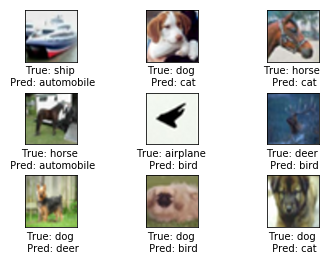

In [51]:
print("Accuracy of the model after training for 5000 epochs")
print_test_accuracy(show_example_errors=True, show_confusion_matrix=False)

In [52]:
print_test_accuracy(show_example_errors=False, show_confusion_matrix=True)

10000
Test-Set Accuracy: 66.3% (6634 / 10000)
Confusion Matrix:
[758  13  53  26  16   5  31   5  65  28] (0) airplane
[ 37 731  16  24   5   4  20   3  38 122] (1) automobile
[ 73   4 546  79  86  55 115  21   9  12] (2) bird
[ 22  11 110 549  47  96 117  20  10  18] (3) cat
[ 30   1  94  80 543  31 138  64  16   3] (4) deer
[ 15   1 105 234  43 473  69  43   5  12] (5) dog
[  6   6  37  51  12  12 858   8   5   5] (6) frog
[ 23   5  57  68  63  48  33 685   1  17] (7) horse
[107  44  20  26  14   5  14   1 729  40] (8) ship
[ 49  69  14  20   7  10  20   8  41 762] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


## Plotting Convolutional Weights (Convolutional Layer 1)

Min:  -0.18933, Max:   0.19291
Mean: 0.00260, Stdev: 0.05520


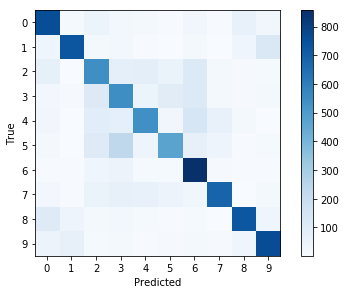

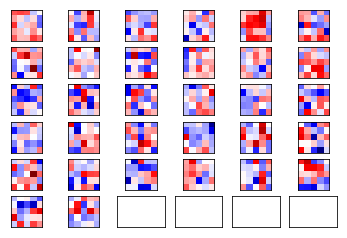

In [53]:
# total 3 input channels
# red: positive weights, blue: negative weights
plot_conv_weights(weights=weights_conv1, input_channel=0)

## Plotting Convolutional Weights (Convolutional Layer 2)

Min:  -0.29123, Max:   0.24299
Mean: 0.00171, Stdev: 0.05491


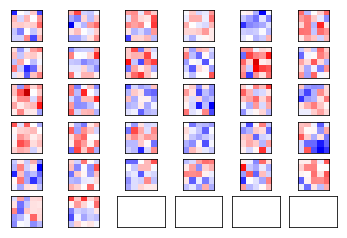

In [54]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

Min:  -0.29123, Max:   0.24299
Mean: 0.00171, Stdev: 0.05491


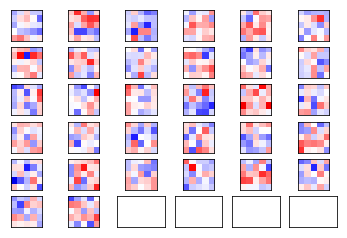

In [55]:
plot_conv_weights(weights=weights_conv2, input_channel=2)

## Helper Function to Plot an Image Output of convolutional layers

In [56]:
def plot_image(image):
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Example 1: Plot an image ouput of convolutional layers

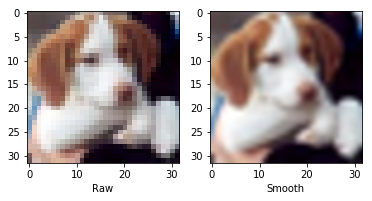

In [57]:
# Plot an image from the test set
img, cls = get_test_image(16)
plot_image(img)

In [58]:
# Use the above raw image as input to the first convolutional layer and plot the output of this layer
# plot_conv_layer(layer_output=)

## Get the predicted class labels for the image

In [59]:
# print the predicted class label and class number for the above image
# the predicted class is an aray of length 10, with each element indicating how confident 
# the neural network is that the image is the given class.
label_pred, cls_pred = sess.run([y_pred, y_pred_cls], feed_dict={x: [img]})

print(label_pred)
print(cls_pred)

[[  1.14470569e-03   5.92623372e-03   1.59189790e-01   5.40704966e-01
    3.02296103e-04   2.62202978e-01   1.39823528e-02   5.22742420e-03
    1.06187700e-03   1.02573764e-02]]
[3]


In [60]:
# print the actual class label for the predicted class
print(class_names[5])

dog


In [61]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

[ 0.001  0.006  0.159  0.541  0.     0.262  0.014  0.005  0.001  0.01 ]


In [62]:
"""In the above case, the element with index number 5 has a value of 0.998 which means that the network is 
99.8% confident that the plotted image is a dog."""

'In the above case, the element with index number 5 has a value of 0.998 which means that the network is \n99.8% confident that the plotted image is a dog.'

## Example 2: Plot an image ouput of convolutional layers

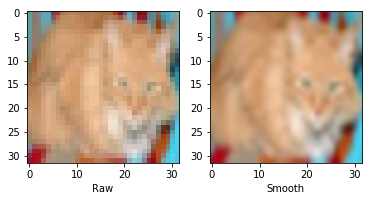

In [63]:
# Plot an image from the test set
img, cls = get_test_image(205)
plot_image(img)

In [64]:
# print the predicted class label and class number for the above image
label_pred, cls_pred = sess.run([y_pred, y_pred_cls], feed_dict={x: [img]})

print(label_pred)
print(cls_pred)

[[ 0.002  0.     0.048  0.622  0.071  0.243  0.013  0.001  0.001  0.   ]]
[3]


In [65]:
# print the actual class label for the predicted class
print(class_names[3])

cat


In [66]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

[ 0.002  0.     0.048  0.622  0.071  0.243  0.013  0.001  0.001  0.   ]


## Example 3: Plot an image ouput of convolutional layers

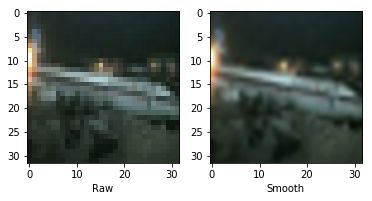

[ 0.552  0.139  0.151  0.014  0.009  0.001  0.02   0.003  0.088  0.022]
[0]
airplane


In [67]:
# Plot an image from the test set
img, cls = get_test_image(1001)
plot_image(img)

# print the predicted class label and class number for the above image
label_pred, cls_pred = sess.run([y_pred, y_pred_cls], feed_dict={x: [img]})

# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])
print(cls_pred)

# print the actual class label for the predicted class
print(class_names[0])

## Example 4: Plot an image ouput of convolutional layers

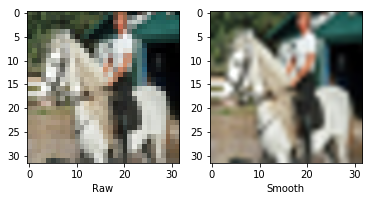

[ 0.     0.     0.001  0.009  0.032  0.048  0.002  0.904  0.     0.003]
[7]
horse
deer


In [68]:
# Plot an image from the test set
img, cls = get_test_image(56)
plot_image(img)

# print the predicted class label and class number for the above image
label_pred, cls_pred = sess.run([y_pred, y_pred_cls], feed_dict={x: [img]})

# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])
print(cls_pred)

# print the actual class label for the predicted class
print(class_names[7])
print(class_names[4])

## Example 5: Plot an image ouput of convolutional layers

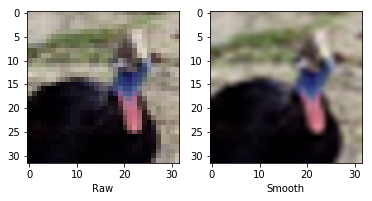

[ 0.023  0.39   0.024  0.022  0.016  0.008  0.098  0.015  0.051  0.352]
[1]
automobile
bird
cat


In [69]:
# Plot an image from the test set
img, cls = get_test_image(5215)
plot_image(img)

# print the predicted class label and class number for the above image
label_pred, cls_pred = sess.run([y_pred, y_pred_cls], feed_dict={x: [img]})

# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])
print(cls_pred)

# print the actual class label for the predicted class
print(class_names[1])
print(class_names[2])
print(class_names[3])

In [71]:
# sess.close()